In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [22]:
tf = transforms.Compose([transforms.ToTensor(),
 transforms.Normalize((0.1307,), (0.3081,))])

In [23]:
#3
train_loader = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=True, transform=tf),
batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=False, transform=tf),
batch_size=64, shuffle=True)

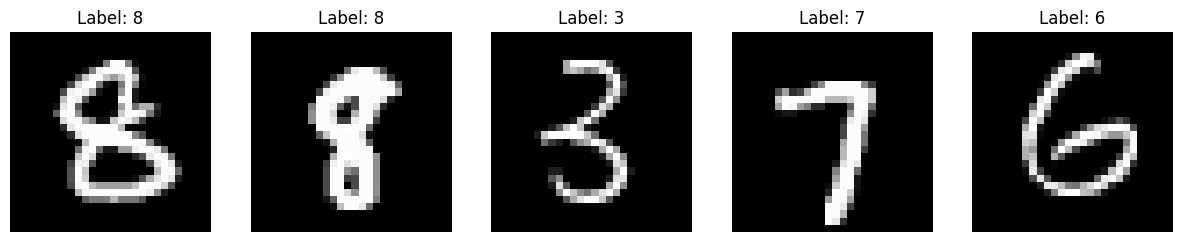

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Début du code
batch = next(iter(train_loader))
x = batch[0][:5]  # Sélection des 5 premières images
y = batch[1][:5]  # Sélection des 5 premières étiquettes

# Configuration de la figure pour afficher les images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Boucle pour afficher chaque image
for i in range(5):
    # Convertir le tenseur en numpy array et réajuster les dimensions pour l'affichage
    image = x[i].numpy().squeeze()  
    label = y[i].item()  # Extraire l'étiquette de l'image

    axes[i].imshow(image, cmap='gray')  # Afficher l'image en niveaux de gris
    axes[i].set_title(f'Label: {label}')  # Ajouter l'étiquette en tant que titre
    axes[i].axis('off')  # Cacher les axes pour un affichage plus propre

plt.show()  # Afficher toutes les images
